# Regression Experiments 2 - using weekly averaged data

This is another version of the regression experiements 2 notebook, using a different dataset.

# Setup:

---

In [3]:
# Required imports
import pandas as pd
import json

rounded_train = pd.read_csv('..\data\train_with_weekly_avg_rounded_score.csv')
rounded_test = pd.read_csv('..\data\test_with_weekly_avg_rounded_score.csv')
raw_train = pd.read_csv('..\data\train_with_weekly_avg.csv')
raw_test = pd.read_csv('..\data\test_with_weekly_avg.csv')
fips_map = open('..\data\fips_map.json')
fips_map = json.load(fips_map)

In [19]:
# Convenience function to get coordinates from fips code
from functools import lru_cache
@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(int(fips_code))
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]


In [20]:
#add a lat and long column without dropping the fips column
def interpret_fips(df):
    '''Turn the fips column into a latitude/longitude pair'''
    coords = pd.DataFrame(df['fips'].apply(fips_to_coordinate).tolist(), columns=['lat', 'long'])
    df = pd.concat([df, coords], axis=1)
    return df

In [21]:
def add_lag_features(groupbykey:str,shiftcol:str,shiftnum:int,basenum:int,df:pd.DataFrame):
    '''
    This convenience function lags the shiftcol by num_weeks after grouping by groupby.
    The basenum is the number of weeks to ignore before adding lag. For example, 
    If you want to lag the most recent week, you would have a base of 0, and a num_weeks of 1.
    If you want to lag only the week before the most recent week, you would have a base of 1, and a num_weeks of 1. 
    The shiftcol is the metric you want to add lag features for.
    '''
    for i in range(basenum+1,shiftnum+1):
        df[f'{shiftcol}_lag_{i}'] = df.groupby([groupbykey])[shiftcol].shift(i)
    return df

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_metric(y_true,y_pred,title:str):
    '''Generates a standard regression metric set, as well as a scatter plot to visualize'''
    plt.figure(figsize=(20,10))
    plt.scatter(y_true, y_pred)
    plt.scatter(y_true, y_true)
    plt.title(title+" model vs truth")
    plt.legend(['Model','Truth'])
    plt.xlabel('Real Score')
    plt.ylabel('Predicted Score')
    plt.show()

    # Error metrics
    print("Mean Squared Error: ", mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("R2 Score: ", r2_score(y_true, y_pred))


In [23]:
def shift_target(df:pd.DataFrame, num_weeks:int, target_col:str, groupy:str)->pd.DataFrame:
    '''Shifts the target column by num_weeks after grouping by groupy.'''
    '''The target_col should be the name of the column you are trying to predict.'''
    '''The groupy should be the column you are grouping by. (Most often for us, this will be 'fips')'''
    '''The num_weeks should be the number of weeks you want to shift the target column by.(How far out you want to predict)'''
    '''The df should be the dataframe you are working with.'''
    newdf = df.copy()
    newdf[target_col] = df.groupby([groupy])[target_col].shift(-num_weeks)
    return newdf

In [24]:
def get_fresh_data():
    '''Returns fresh copy of data with some basic preprocessing'''
    _train = raw_train.copy()
    _test = raw_test.copy()
    _train = interpret_fips(_train)
    _test = interpret_fips(_test)
    _train.set_index('date', inplace=True)
    _test.set_index('date', inplace=True)
    return _train, _test

In [25]:
def rm_fips_null(df):
    '''removes fips and all null values'''
    df.drop(['fips'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Experiments:

---

### Basic Catboost Regressor with default parameters, score lag of 4 weeks.

---

In [26]:
raw_train

,date,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,2000-01-04,1001.0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,10.387500,...,15.242500,3.147500,4.342500,2.015000,2.330000,6.110000,7.750000,4.140000,3.615000,1.0
1,2000-01-11,1001.0,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,3.071429,...,8.558571,2.200000,3.305714,1.238571,2.065714,4.418571,6.588571,2.280000,4.307143,2.0
2,2000-01-18,1001.0,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,3.757143,...,9.975714,2.352857,3.257143,1.490000,1.767143,4.870000,6.508571,2.812857,3.692857,2.0
3,2000-01-25,1001.0,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,-1.282857,...,4.508571,2.932857,4.090000,1.814286,2.275714,5.270000,7.174286,3.575714,3.600000,2.0
4,2000-02-01,1001.0,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,...,0.781429,2.362857,3.354286,1.318571,2.037143,4.372857,6.177143,2.580000,3.594286,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756791,2016-11-29,56043.0,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,...,-1.740000,5.114286,7.270000,3.101429,4.167143,7.637143,9.822857,5.165714,4.655714,0.0
2756792,2016-12-06,56043.0,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,...,-5.887143,3.517143,5.534286,1.837143,3.694286,5.210000,7.768571,2.905714,4.862857,0.0
2756793,2016-12-13,56043.0,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,-11.791429,...,-8.364286,3.370000,5.521429,1.435714,4.085714,5.080000,7.635714,2.311429,5.322857,0.0
2756794,2016-12-20,56043.0,0.812857,82.752857,1.757143,-9.688571,-13.777143,-13.368571,-3.805714,-15.451429,...,-10.667143,3.735714,5.688571,1.648571,4.038571,5.287143,7.750000,2.740000,5.008571,0.0


In [35]:
train2 = raw_train.copy()  #REQUIRED STEP
test2 = raw_test.copy() #REQUIRED STEP

In [36]:
train2 = interpret_fips(train2) #REQUIRED STEP
test2 = interpret_fips(test2) #REQUIRED STEP
train2.set_index('date',inplace=True) #REQUIRED STEP
test2.set_index('date',inplace=True) #REQUIRED STEP
train2 = add_lag_features('fips','score',4,0,train2) #can play around with these
test2 = add_lag_features('fips','score',4,0,test2)

In [38]:
NUM_WEEKS_TO_FORECAST = 1

In [39]:
train2 = shift_target(train2, NUM_WEEKS_TO_FORECAST, 'score', 'fips') #REQUIRED STEP, but you can change the number of weeks to forecast
test2 = shift_target(test2, NUM_WEEKS_TO_FORECAST, 'score', 'fips')

In [41]:
train2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
test2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
train2.dropna(inplace=True) #REQUIRED STEP
test2.dropna(inplace=True)  #REQUIRED STEP

In [42]:
train2


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,lat,long,score_lag_1,score_lag_2,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,0.781429,...,6.177143,2.580000,3.594286,1.0,32.532237,-86.646440,2.0,2.0,2.0000,1.0000
2000-02-08,0.000000,101.054286,3.545714,4.377143,-1.231429,-1.180000,12.318571,-2.164286,14.480000,3.640000,...,5.880000,1.654286,4.227143,1.0,32.532237,-86.646440,1.0,2.0,2.0000,2.0000
2000-02-15,1.708571,100.215714,8.087143,13.325714,10.057143,10.061429,20.042857,6.375714,13.668571,12.987143,...,7.050000,2.547143,4.504286,1.0,32.532237,-86.646440,1.0,1.0,2.0000,2.0000
2000-02-22,0.917143,100.998571,7.101429,12.237143,7.655714,7.668571,19.608571,5.337143,14.271429,12.130000,...,6.535714,3.157143,3.380000,1.0,32.532237,-86.646440,1.0,1.0,1.0000,2.0000
2000-02-29,3.852857,100.828571,7.628571,14.057143,9.621429,9.625714,21.797143,7.042857,14.752857,14.005714,...,6.948571,3.407143,3.541429,1.0,32.532237,-86.646440,1.0,1.0,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-22,2.598571,82.920000,3.245714,-0.251429,-4.988571,-4.938571,5.287143,-4.571429,9.857143,-1.217143,...,7.957143,2.615714,5.344286,0.0,43.878831,-107.669052,0.0,0.0,0.0056,0.0056
2016-11-29,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,8.752857,-1.740000,...,9.822857,5.165714,4.655714,0.0,43.878831,-107.669052,0.0,0.0,0.0000,0.0056
2016-12-06,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,-5.887143,...,7.768571,2.905714,4.862857,0.0,43.878831,-107.669052,0.0,0.0,0.0000,0.0000


In [43]:
from catboost import CatBoostRegressor

model2 = CatBoostRegressor()

model2.fit(train2.drop(['score'],axis=1),train2['score'], verbose=False)

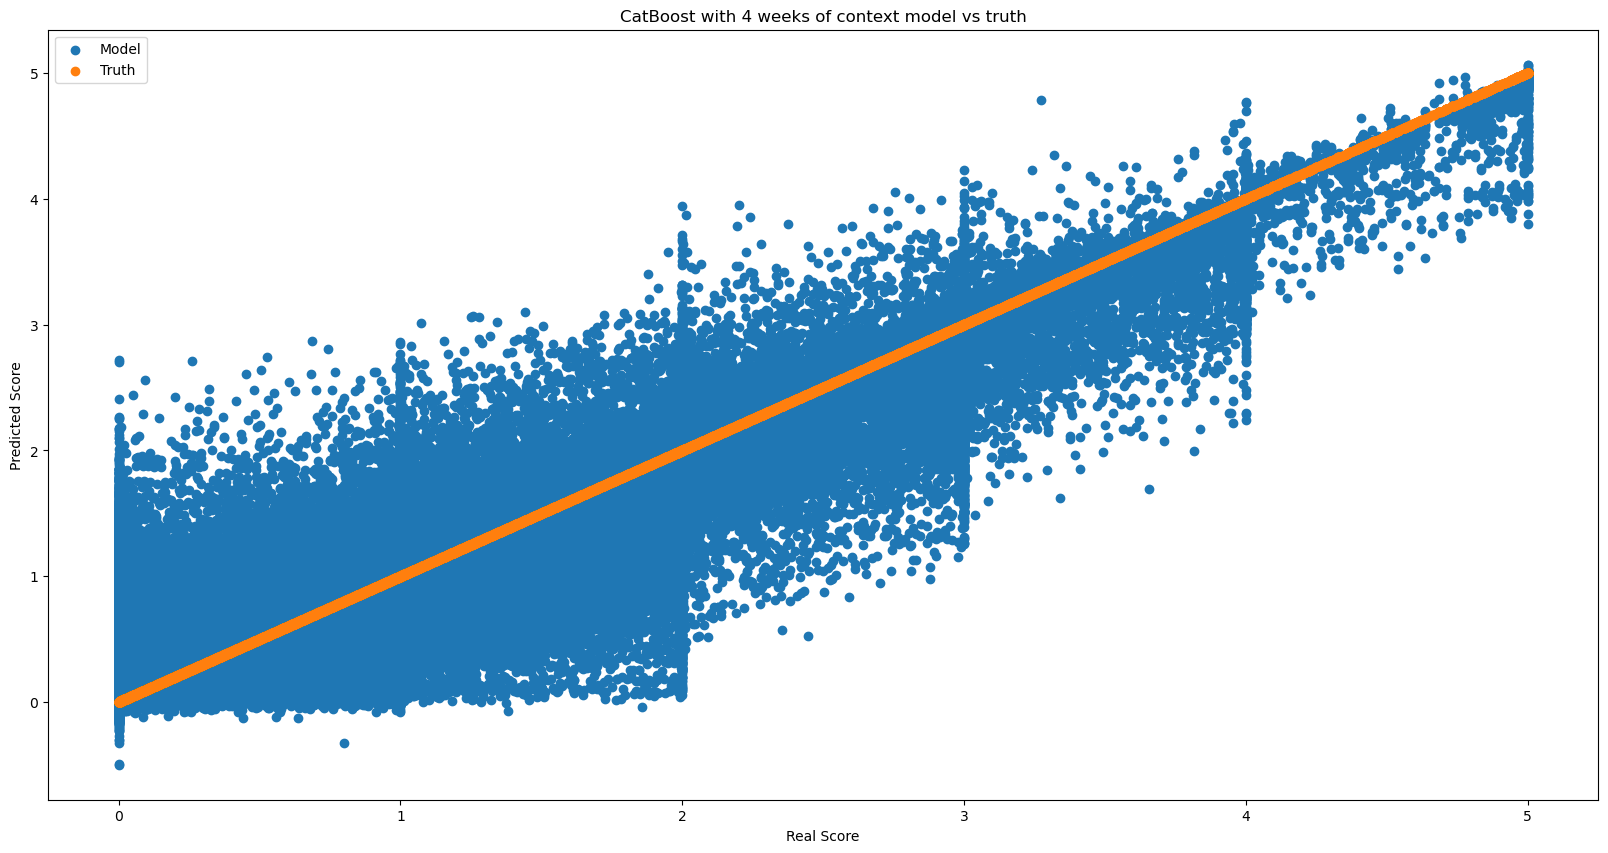

Mean Squared Error:  0.08450955947453061
Mean Absolute Error:  0.15449726096350955
R2 Score:  0.8813800510280041


In [44]:
model2_preds = model2.predict(test2.drop(['score'],axis=1))

regression_metric(test2['score'], model2_preds, 'CatBoost with 4 weeks of context')

In [45]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,74.692853
1,PRECTOT,10.742701
2,long,2.550798
3,T2M_MAX,1.473339
4,T2M_RANGE,1.367733
5,lat,1.315545
6,score_lag_2,1.026134
7,TS,0.836574
8,QV2M,0.832592
9,T2M_MIN,0.790637


In [52]:
from catboost import CatBoostRegressor
def cbm_model(num_weeks_to_forecast):
    '''wraps all of the logic above into a single function'''
    _train = raw_train.copy()
    _test = raw_test.copy()
    _train = interpret_fips(_train)
    _test = interpret_fips(_test)
    _train.set_index('date',inplace=True)
    _test.set_index('date',inplace=True)
    _train = add_lag_features('fips','score',4,0,_train)
    _test = add_lag_features('fips','score',4,0,_test)
    _train = shift_target(_train, num_weeks_to_forecast, 'score', 'fips')
    _test = shift_target(_test, num_weeks_to_forecast, 'score', 'fips')
    _train.drop(['fips'],axis=1,inplace=True)
    _test.drop(['fips'],axis=1,inplace=True)
    _train.dropna(inplace=True)
    _test.dropna(inplace=True)
    _model = CatBoostRegressor()
    _model.fit(_train.drop(['score'],axis=1),_train['score'], verbose=False)
    _model_preds = _model.predict(_test.drop(['score'],axis=1))
    regression_metric(_test['score'], _model_preds, f'CatBoost with 4 weeks of context, forecasting {num_weeks_to_forecast} weeks ahead')
    return _model   

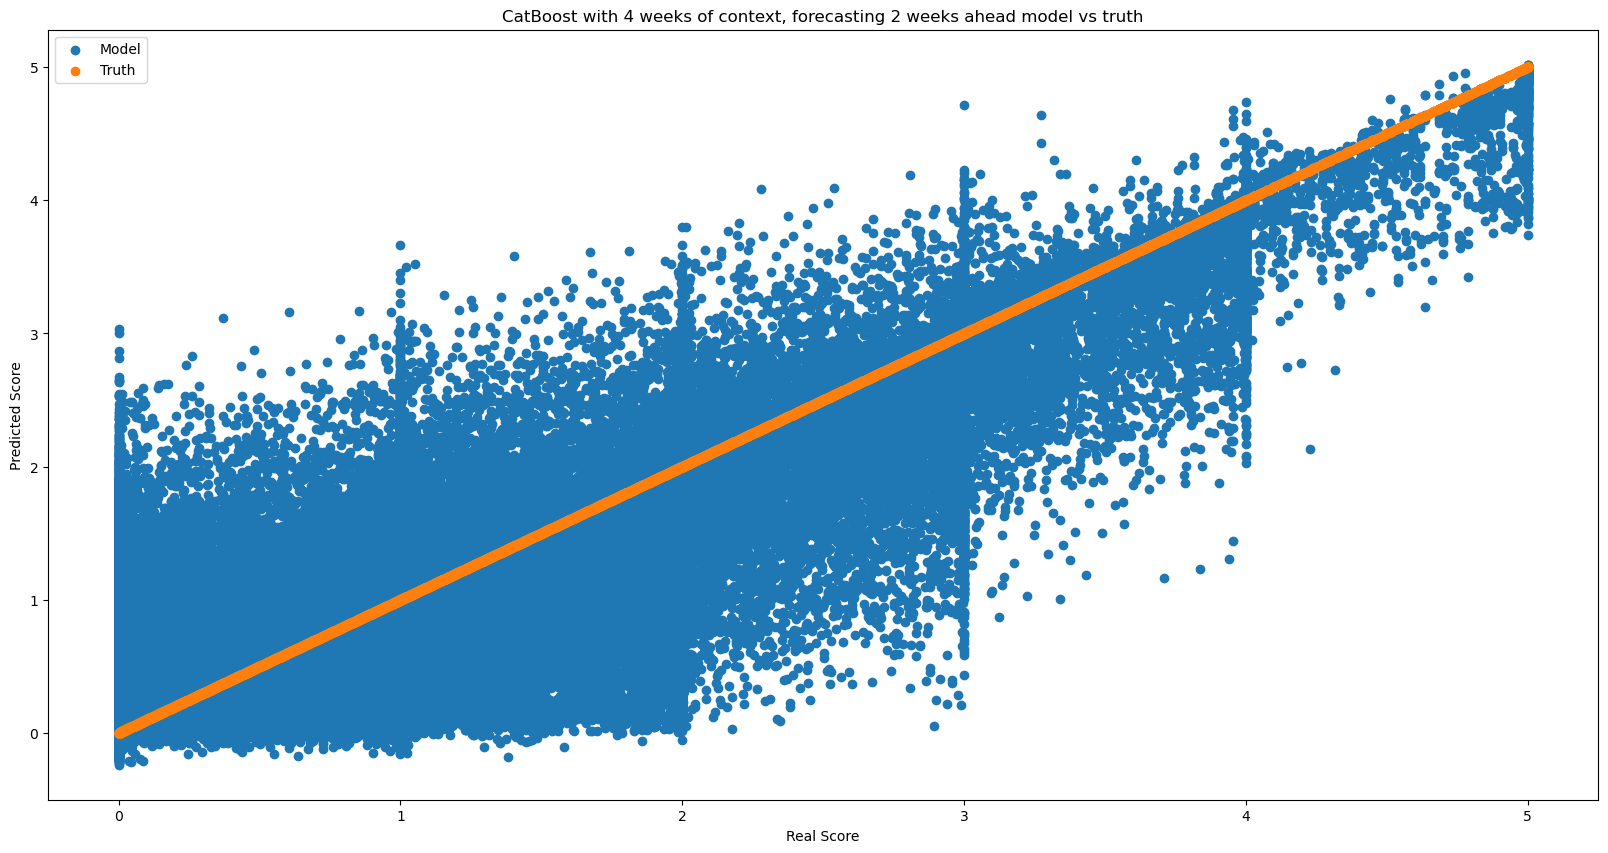

Mean Squared Error:  0.13841402299941175
Mean Absolute Error:  0.21059172813995483
R2 Score:  0.8064875142566917


In [53]:
cbm_model(2)

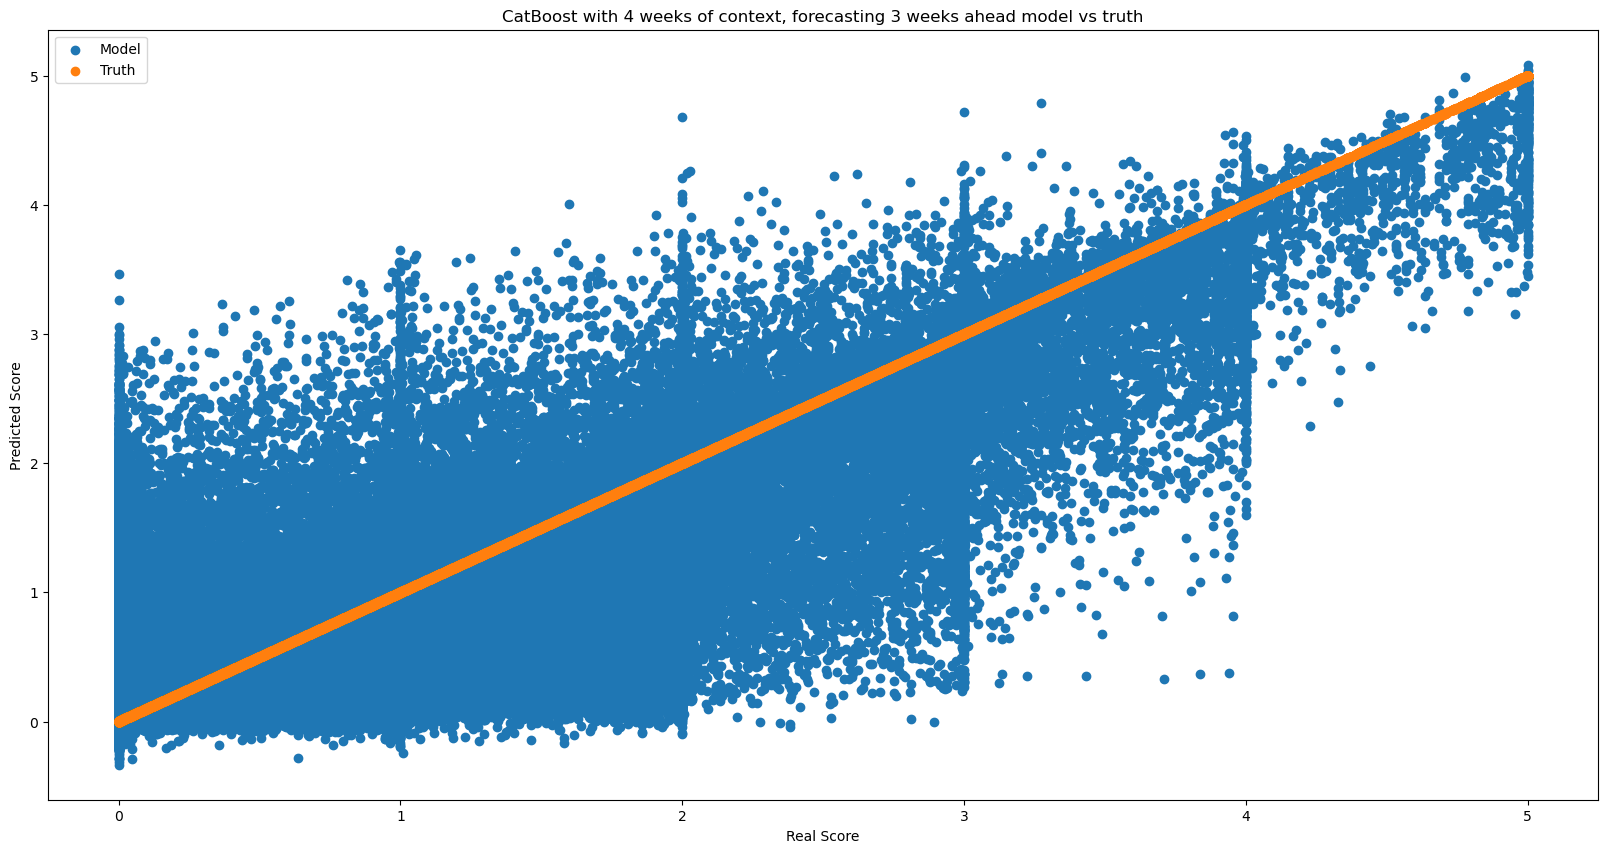

Mean Squared Error:  0.19849424486272982
Mean Absolute Error:  0.2631692741729044
R2 Score:  0.7236749468045851


In [54]:
cbm_model(3)

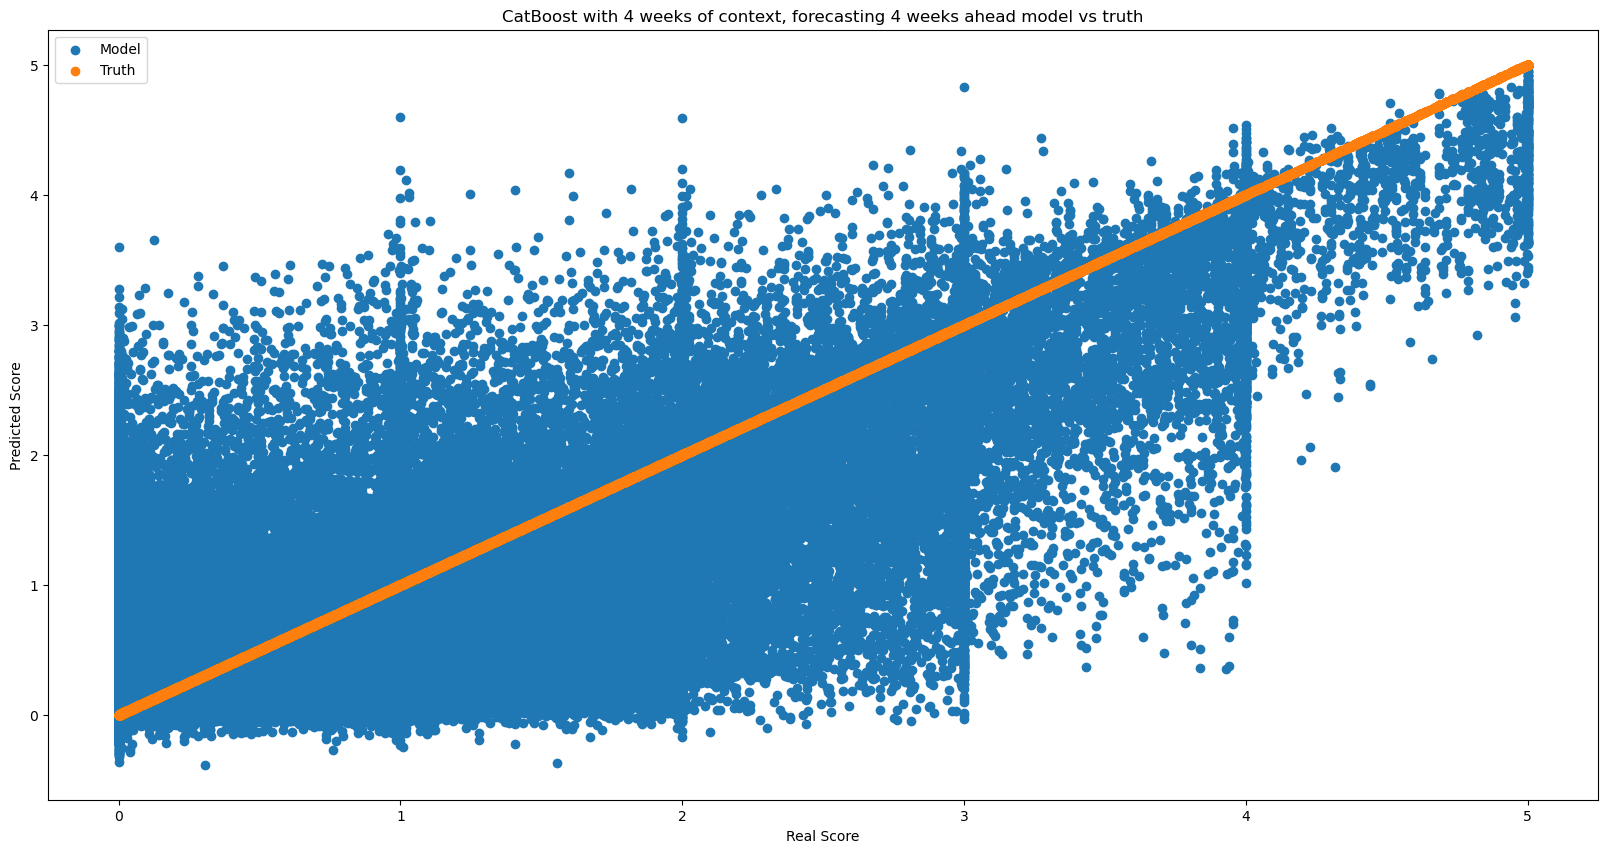

Mean Squared Error:  0.2573331724050937
Mean Absolute Error:  0.31053690544474105
R2 Score:  0.6434437780002498


In [55]:
cbm_model(4)

### Basic Catboost Regressor, 8 week lag, offset by 2 weeks.

---
I want to see if more score lag data but offset by 2 weeks will preserve the score

In [47]:
train3, test3 = get_fresh_data()
train3 = add_lag_features('fips','score',8,2,train3)
test3 = add_lag_features('fips','score',8,2,test3)
train3 = shift_target(train3, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test3 = shift_target(test3, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train3 = rm_fips_null(train3)
test3 = rm_fips_null(test3)

In [48]:
train3

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_RANGE,score,lat,long,score_lag_3,score_lag_4,score_lag_5,score_lag_6,score_lag_7,score_lag_8
date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,3.852857,100.828571,7.628571,14.057143,9.621429,9.625714,21.797143,7.042857,14.752857,14.005714,...,3.541429,1.0000,32.532237,-86.646440,1.0000,1.0000,2.0000,2.0000,2.0000,1.0000
2000-03-07,1.347143,100.318571,7.094286,14.390000,8.392857,8.401429,22.034286,7.078571,14.955714,13.580000,...,3.585714,1.4905,32.532237,-86.646440,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000
2000-03-14,3.965714,100.504286,7.832857,13.650000,8.615714,8.634286,20.827143,6.177143,14.647143,13.462857,...,3.835714,1.5019,32.532237,-86.646440,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000
2000-03-21,9.472857,100.268571,7.995714,13.514286,10.242857,10.244286,19.980000,8.058571,11.922857,13.512857,...,3.135714,1.2818,32.532237,-86.646440,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000
2000-03-28,1.378571,100.035714,9.035714,15.937143,12.217143,12.218571,23.321429,9.344286,13.972857,15.885714,...,4.257143,1.0000,32.532237,-86.646440,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-22,2.598571,82.920000,3.245714,-0.251429,-4.988571,-4.938571,5.287143,-4.571429,9.857143,-1.217143,...,5.344286,0.0000,43.878831,-107.669052,0.0056,0.0056,0.0056,0.0056,0.0886,0.6060
2016-11-29,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,8.752857,-1.740000,...,4.655714,0.0000,43.878831,-107.669052,0.0000,0.0056,0.0056,0.0056,0.0056,0.0886
2016-12-06,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,-5.887143,...,4.862857,0.0000,43.878831,-107.669052,0.0000,0.0000,0.0056,0.0056,0.0056,0.0056


In [49]:
from catboost import CatBoostRegressor

model3 = CatBoostRegressor()
model3.fit(train3.drop(['score'],axis=1),train3['score'], verbose=False)

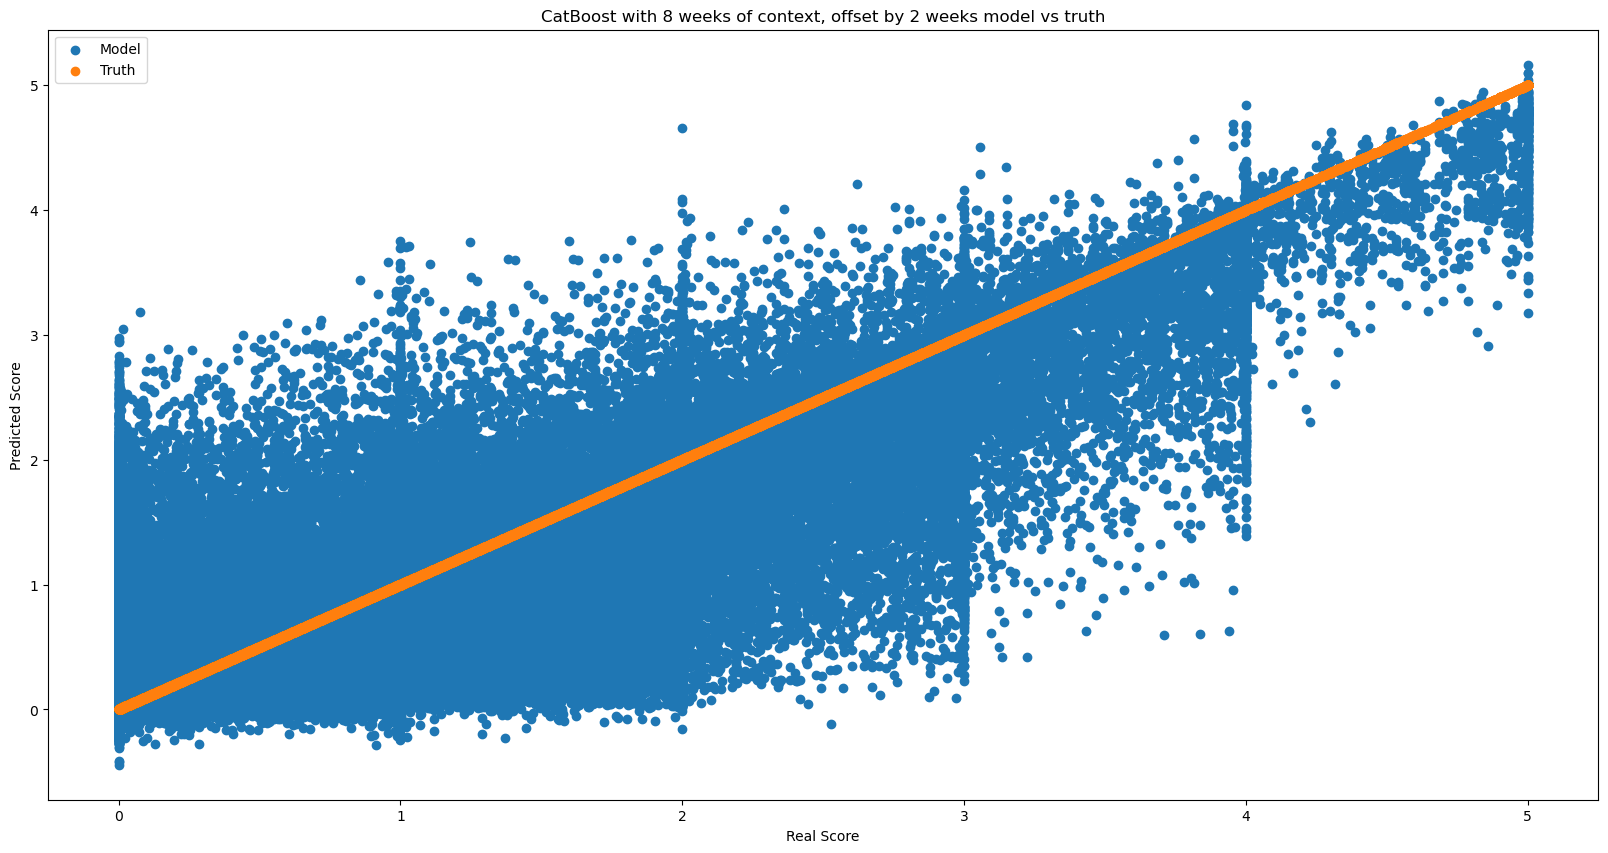

Mean Squared Error:  0.19041860512489903
Mean Absolute Error:  0.2552800693649011
R2 Score:  0.7376030819069963


In [50]:
model3_preds = model3.predict(test3.drop(['score'],axis=1))
regression_metric(test3['score'], model3_preds, 'CatBoost with 8 weeks of context, offset by 2 weeks')

In [51]:
model3.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_3,56.165876
1,PRECTOT,7.270921
2,long,6.255009
3,T2M_MAX,4.206921
4,T2M_RANGE,4.037375
5,lat,3.187514
6,QV2M,2.821020
7,T2M_MIN,2.783532
8,T2MDEW,2.568702
9,TS,1.999532


### Basic CatBoost Regressor, very little score lag, mostly measurement lag

---

In [57]:
train4, test4 = get_fresh_data()

In [58]:
train4

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,lat,long
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,1001.0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,10.387500,10.752500,...,4.342500,2.015000,2.330000,6.110000,7.750000,4.140000,3.615000,1.0,32.532237,-86.646440
2000-01-11,1001.0,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,3.071429,12.662857,...,3.305714,1.238571,2.065714,4.418571,6.588571,2.280000,4.307143,2.0,32.532237,-86.646440
2000-01-18,1001.0,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,3.757143,13.177143,...,3.257143,1.490000,1.767143,4.870000,6.508571,2.812857,3.692857,2.0,32.532237,-86.646440
2000-01-25,1001.0,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,-1.282857,11.498571,...,4.090000,1.814286,2.275714,5.270000,7.174286,3.575714,3.600000,2.0,32.532237,-86.646440
2000-02-01,1001.0,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,...,3.354286,1.318571,2.037143,4.372857,6.177143,2.580000,3.594286,1.0,32.532237,-86.646440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-29,56043.0,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,8.752857,...,7.270000,3.101429,4.167143,7.637143,9.822857,5.165714,4.655714,0.0,43.878831,-107.669052
2016-12-06,56043.0,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,...,5.534286,1.837143,3.694286,5.210000,7.768571,2.905714,4.862857,0.0,43.878831,-107.669052
2016-12-13,56043.0,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,-11.791429,9.260000,...,5.521429,1.435714,4.085714,5.080000,7.635714,2.311429,5.322857,0.0,43.878831,-107.669052


In [59]:
cols = train4.columns.to_list()
cols.remove('fips')
cols.remove('score')
cols.remove('lat')
cols.remove('long')
for x in cols:
    train4 = add_lag_features('fips',x,4,0,train4)
    test4 = add_lag_features('fips',x,4,0,test4)

train4 = add_lag_features('fips','score',4,2,train4)
test4 = add_lag_features('fips','score',4,2,test4)

In [60]:
train4

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS50M_MIN_lag_1,WS50M_MIN_lag_2,WS50M_MIN_lag_3,WS50M_MIN_lag_4,WS50M_RANGE_lag_1,WS50M_RANGE_lag_2,WS50M_RANGE_lag_3,WS50M_RANGE_lag_4,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,1001.0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,10.387500,10.752500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,1001.0,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,3.071429,12.662857,...,4.140000,NaN,NaN,NaN,3.615000,NaN,NaN,NaN,NaN,NaN
2000-01-18,1001.0,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,3.757143,13.177143,...,2.280000,4.140000,NaN,NaN,4.307143,3.615000,NaN,NaN,NaN,NaN
2000-01-25,1001.0,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,-1.282857,11.498571,...,2.812857,2.280000,4.140000,NaN,3.692857,4.307143,3.615000,NaN,1.0,NaN
2000-02-01,1001.0,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,...,3.575714,2.812857,2.280000,4.140000,3.600000,3.692857,4.307143,3.615000,2.0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-29,56043.0,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,8.752857,...,2.615714,2.262857,1.760000,3.014286,5.344286,4.915714,3.558571,5.940000,0.0,0.0056
2016-12-06,56043.0,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,...,5.165714,2.615714,2.262857,1.760000,4.655714,5.344286,4.915714,3.558571,0.0,0.0000
2016-12-13,56043.0,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,-11.791429,9.260000,...,2.905714,5.165714,2.615714,2.262857,4.862857,4.655714,5.344286,4.915714,0.0,0.0000


In [61]:
NUM_WEEKS_TO_FORECAST = 1

In [62]:
train4 = shift_target(train4, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test4 = shift_target(test4, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train4 = rm_fips_null(train4)
test4 = rm_fips_null(test4)

In [63]:
train4.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_MIN_lag_1,WS50M_MIN_lag_2,WS50M_MIN_lag_3,WS50M_MIN_lag_4,WS50M_RANGE_lag_1,WS50M_RANGE_lag_2,WS50M_RANGE_lag_3,WS50M_RANGE_lag_4,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,0.781429,...,3.575714,2.812857,2.280000,4.140000,3.600000,3.692857,4.307143,3.615000,2.0,1.0
2000-02-08,0.000000,101.054286,3.545714,4.377143,-1.231429,-1.180000,12.318571,-2.164286,14.480000,3.640000,...,2.580000,3.575714,2.812857,2.280000,3.594286,3.600000,3.692857,4.307143,2.0,2.0
2000-02-15,1.708571,100.215714,8.087143,13.325714,10.057143,10.061429,20.042857,6.375714,13.668571,12.987143,...,1.654286,2.580000,3.575714,2.812857,4.227143,3.594286,3.600000,3.692857,2.0,2.0
2000-02-22,0.917143,100.998571,7.101429,12.237143,7.655714,7.668571,19.608571,5.337143,14.271429,12.130000,...,2.547143,1.654286,2.580000,3.575714,4.504286,4.227143,3.594286,3.600000,1.0,2.0
2000-02-29,3.852857,100.828571,7.628571,14.057143,9.621429,9.625714,21.797143,7.042857,14.752857,14.005714,...,3.157143,2.547143,1.654286,2.580000,3.380000,4.504286,4.227143,3.594286,1.0,1.0


In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# pca = PCA(n_components=93)
# pca.fit(train4.drop(['score'],axis=1))

In [ ]:
# plt.figure(figsize=(40,10))
# plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show()

In [ ]:
# pca = PCA(n_components=10)
# trainX = pca.fit_transform(train4.drop(['score'],axis=1))
# testX = pca.transform(test4.drop(['score'],axis=1))



In [88]:
trainX = train4.drop(['score'],axis=1)
testX = test4.drop(['score'],axis=1)

In [89]:
# train catboost regressor
from catboost import CatBoostRegressor
model4 = CatBoostRegressor()
model4.fit(trainX,train4['score'], verbose=True)

Learning rate set to 0.143013
0:	learn: 1.0885334	total: 666ms	remaining: 11m 5s
1:	learn: 0.9751474	total: 1.13s	remaining: 9m 24s
2:	learn: 0.8814030	total: 1.59s	remaining: 8m 47s
3:	learn: 0.8032167	total: 2.07s	remaining: 8m 35s
4:	learn: 0.7388801	total: 2.59s	remaining: 8m 35s
5:	learn: 0.6864474	total: 3.05s	remaining: 8m 25s
6:	learn: 0.6436870	total: 3.53s	remaining: 8m 20s
7:	learn: 0.6099229	total: 4.03s	remaining: 8m 19s
8:	learn: 0.5827816	total: 4.61s	remaining: 8m 27s
9:	learn: 0.5607743	total: 5.11s	remaining: 8m 25s
10:	learn: 0.5436565	total: 5.54s	remaining: 8m 17s
11:	learn: 0.5291894	total: 5.98s	remaining: 8m 12s
12:	learn: 0.5177948	total: 6.35s	remaining: 8m 2s
13:	learn: 0.5086208	total: 6.83s	remaining: 8m 1s
14:	learn: 0.5006392	total: 7.35s	remaining: 8m 2s
15:	learn: 0.4937610	total: 7.83s	remaining: 8m 1s
16:	learn: 0.4881476	total: 8.23s	remaining: 7m 55s
17:	learn: 0.4834931	total: 8.72s	remaining: 7m 55s
18:	learn: 0.4792732	total: 9.15s	remaining: 7m 

157:	learn: 0.4190949	total: 1m 18s	remaining: 6m 57s
158:	learn: 0.4189439	total: 1m 18s	remaining: 6m 56s
159:	learn: 0.4188445	total: 1m 19s	remaining: 6m 56s
160:	learn: 0.4187836	total: 1m 19s	remaining: 6m 55s
161:	learn: 0.4186998	total: 1m 20s	remaining: 6m 54s
162:	learn: 0.4186002	total: 1m 20s	remaining: 6m 54s
163:	learn: 0.4185349	total: 1m 21s	remaining: 6m 53s
164:	learn: 0.4184272	total: 1m 21s	remaining: 6m 52s
165:	learn: 0.4183347	total: 1m 21s	remaining: 6m 51s
166:	learn: 0.4182382	total: 1m 22s	remaining: 6m 50s
167:	learn: 0.4181449	total: 1m 22s	remaining: 6m 50s
168:	learn: 0.4180432	total: 1m 23s	remaining: 6m 49s
169:	learn: 0.4179398	total: 1m 23s	remaining: 6m 48s
170:	learn: 0.4178487	total: 1m 24s	remaining: 6m 47s
171:	learn: 0.4177806	total: 1m 24s	remaining: 6m 46s
172:	learn: 0.4177062	total: 1m 24s	remaining: 6m 45s
173:	learn: 0.4176412	total: 1m 25s	remaining: 6m 44s
174:	learn: 0.4175560	total: 1m 25s	remaining: 6m 44s
175:	learn: 0.4174882	total:

310:	learn: 0.4080901	total: 2m 25s	remaining: 5m 21s
311:	learn: 0.4080160	total: 2m 25s	remaining: 5m 21s
312:	learn: 0.4079385	total: 2m 26s	remaining: 5m 20s
313:	learn: 0.4079007	total: 2m 26s	remaining: 5m 20s
314:	learn: 0.4078616	total: 2m 26s	remaining: 5m 19s
315:	learn: 0.4077973	total: 2m 27s	remaining: 5m 19s
316:	learn: 0.4077509	total: 2m 27s	remaining: 5m 18s
317:	learn: 0.4076791	total: 2m 28s	remaining: 5m 17s
318:	learn: 0.4076298	total: 2m 28s	remaining: 5m 16s
319:	learn: 0.4075855	total: 2m 28s	remaining: 5m 16s
320:	learn: 0.4075369	total: 2m 29s	remaining: 5m 15s
321:	learn: 0.4074893	total: 2m 29s	remaining: 5m 15s
322:	learn: 0.4074391	total: 2m 30s	remaining: 5m 14s
323:	learn: 0.4073966	total: 2m 30s	remaining: 5m 13s
324:	learn: 0.4073240	total: 2m 30s	remaining: 5m 13s
325:	learn: 0.4072527	total: 2m 31s	remaining: 5m 12s
326:	learn: 0.4072028	total: 2m 31s	remaining: 5m 12s
327:	learn: 0.4071459	total: 2m 32s	remaining: 5m 11s
328:	learn: 0.4070826	total:

463:	learn: 0.4004435	total: 3m 30s	remaining: 4m 2s
464:	learn: 0.4004019	total: 3m 30s	remaining: 4m 2s
465:	learn: 0.4003694	total: 3m 30s	remaining: 4m 1s
466:	learn: 0.4003174	total: 3m 31s	remaining: 4m 1s
467:	learn: 0.4002889	total: 3m 31s	remaining: 4m
468:	learn: 0.4002390	total: 3m 31s	remaining: 4m
469:	learn: 0.4001920	total: 3m 32s	remaining: 3m 59s
470:	learn: 0.4001545	total: 3m 32s	remaining: 3m 59s
471:	learn: 0.4000873	total: 3m 33s	remaining: 3m 58s
472:	learn: 0.4000415	total: 3m 33s	remaining: 3m 58s
473:	learn: 0.3999817	total: 3m 34s	remaining: 3m 57s
474:	learn: 0.3999369	total: 3m 34s	remaining: 3m 57s
475:	learn: 0.3998827	total: 3m 35s	remaining: 3m 56s
476:	learn: 0.3998351	total: 3m 35s	remaining: 3m 56s
477:	learn: 0.3997765	total: 3m 35s	remaining: 3m 55s
478:	learn: 0.3997360	total: 3m 36s	remaining: 3m 55s
479:	learn: 0.3997105	total: 3m 36s	remaining: 3m 54s
480:	learn: 0.3996566	total: 3m 37s	remaining: 3m 54s
481:	learn: 0.3995973	total: 3m 37s	rema

617:	learn: 0.3943536	total: 4m 35s	remaining: 2m 50s
618:	learn: 0.3943160	total: 4m 36s	remaining: 2m 49s
619:	learn: 0.3942824	total: 4m 36s	remaining: 2m 49s
620:	learn: 0.3942481	total: 4m 36s	remaining: 2m 48s
621:	learn: 0.3942081	total: 4m 37s	remaining: 2m 48s
622:	learn: 0.3941658	total: 4m 37s	remaining: 2m 47s
623:	learn: 0.3941198	total: 4m 38s	remaining: 2m 47s
624:	learn: 0.3940869	total: 4m 38s	remaining: 2m 47s
625:	learn: 0.3940554	total: 4m 38s	remaining: 2m 46s
626:	learn: 0.3940239	total: 4m 39s	remaining: 2m 46s
627:	learn: 0.3939904	total: 4m 39s	remaining: 2m 45s
628:	learn: 0.3939569	total: 4m 40s	remaining: 2m 45s
629:	learn: 0.3939102	total: 4m 40s	remaining: 2m 44s
630:	learn: 0.3938746	total: 4m 41s	remaining: 2m 44s
631:	learn: 0.3938430	total: 4m 41s	remaining: 2m 43s
632:	learn: 0.3938105	total: 4m 41s	remaining: 2m 43s
633:	learn: 0.3937763	total: 4m 42s	remaining: 2m 42s
634:	learn: 0.3937386	total: 4m 42s	remaining: 2m 42s
635:	learn: 0.3936987	total:

770:	learn: 0.3892746	total: 5m 42s	remaining: 1m 41s
771:	learn: 0.3892333	total: 5m 43s	remaining: 1m 41s
772:	learn: 0.3892064	total: 5m 43s	remaining: 1m 40s
773:	learn: 0.3891805	total: 5m 44s	remaining: 1m 40s
774:	learn: 0.3891544	total: 5m 44s	remaining: 1m 40s
775:	learn: 0.3891343	total: 5m 45s	remaining: 1m 39s
776:	learn: 0.3890971	total: 5m 45s	remaining: 1m 39s
777:	learn: 0.3890587	total: 5m 46s	remaining: 1m 38s
778:	learn: 0.3890309	total: 5m 46s	remaining: 1m 38s
779:	learn: 0.3890034	total: 5m 47s	remaining: 1m 37s
780:	learn: 0.3889743	total: 5m 47s	remaining: 1m 37s
781:	learn: 0.3889336	total: 5m 47s	remaining: 1m 37s
782:	learn: 0.3889114	total: 5m 48s	remaining: 1m 36s
783:	learn: 0.3888836	total: 5m 48s	remaining: 1m 36s
784:	learn: 0.3888601	total: 5m 49s	remaining: 1m 35s
785:	learn: 0.3888314	total: 5m 49s	remaining: 1m 35s
786:	learn: 0.3887952	total: 5m 50s	remaining: 1m 34s
787:	learn: 0.3887619	total: 5m 50s	remaining: 1m 34s
788:	learn: 0.3887212	total:

925:	learn: 0.3849295	total: 6m 48s	remaining: 32.6s
926:	learn: 0.3849065	total: 6m 48s	remaining: 32.2s
927:	learn: 0.3848775	total: 6m 49s	remaining: 31.8s
928:	learn: 0.3848611	total: 6m 49s	remaining: 31.3s
929:	learn: 0.3848260	total: 6m 50s	remaining: 30.9s
930:	learn: 0.3848041	total: 6m 50s	remaining: 30.4s
931:	learn: 0.3847762	total: 6m 51s	remaining: 30s
932:	learn: 0.3847454	total: 6m 51s	remaining: 29.6s
933:	learn: 0.3847142	total: 6m 52s	remaining: 29.1s
934:	learn: 0.3846885	total: 6m 52s	remaining: 28.7s
935:	learn: 0.3846655	total: 6m 53s	remaining: 28.2s
936:	learn: 0.3846412	total: 6m 53s	remaining: 27.8s
937:	learn: 0.3846096	total: 6m 54s	remaining: 27.4s
938:	learn: 0.3845618	total: 6m 54s	remaining: 26.9s
939:	learn: 0.3845307	total: 6m 55s	remaining: 26.5s
940:	learn: 0.3844922	total: 6m 55s	remaining: 26.1s
941:	learn: 0.3844571	total: 6m 56s	remaining: 25.6s
942:	learn: 0.3844294	total: 6m 56s	remaining: 25.2s
943:	learn: 0.3843935	total: 6m 57s	remaining: 2

In [90]:
# save catboost regressor
import pickle
pickle.dump(model4, open('model4_regression_experiments_with_weekly_avg.pkl', 'wb'))

In [91]:
import pickle
import pandas as pd
model4 = pickle.load(open('model4_regression_experiments_with_weekly_avg.pkl', 'rb'))

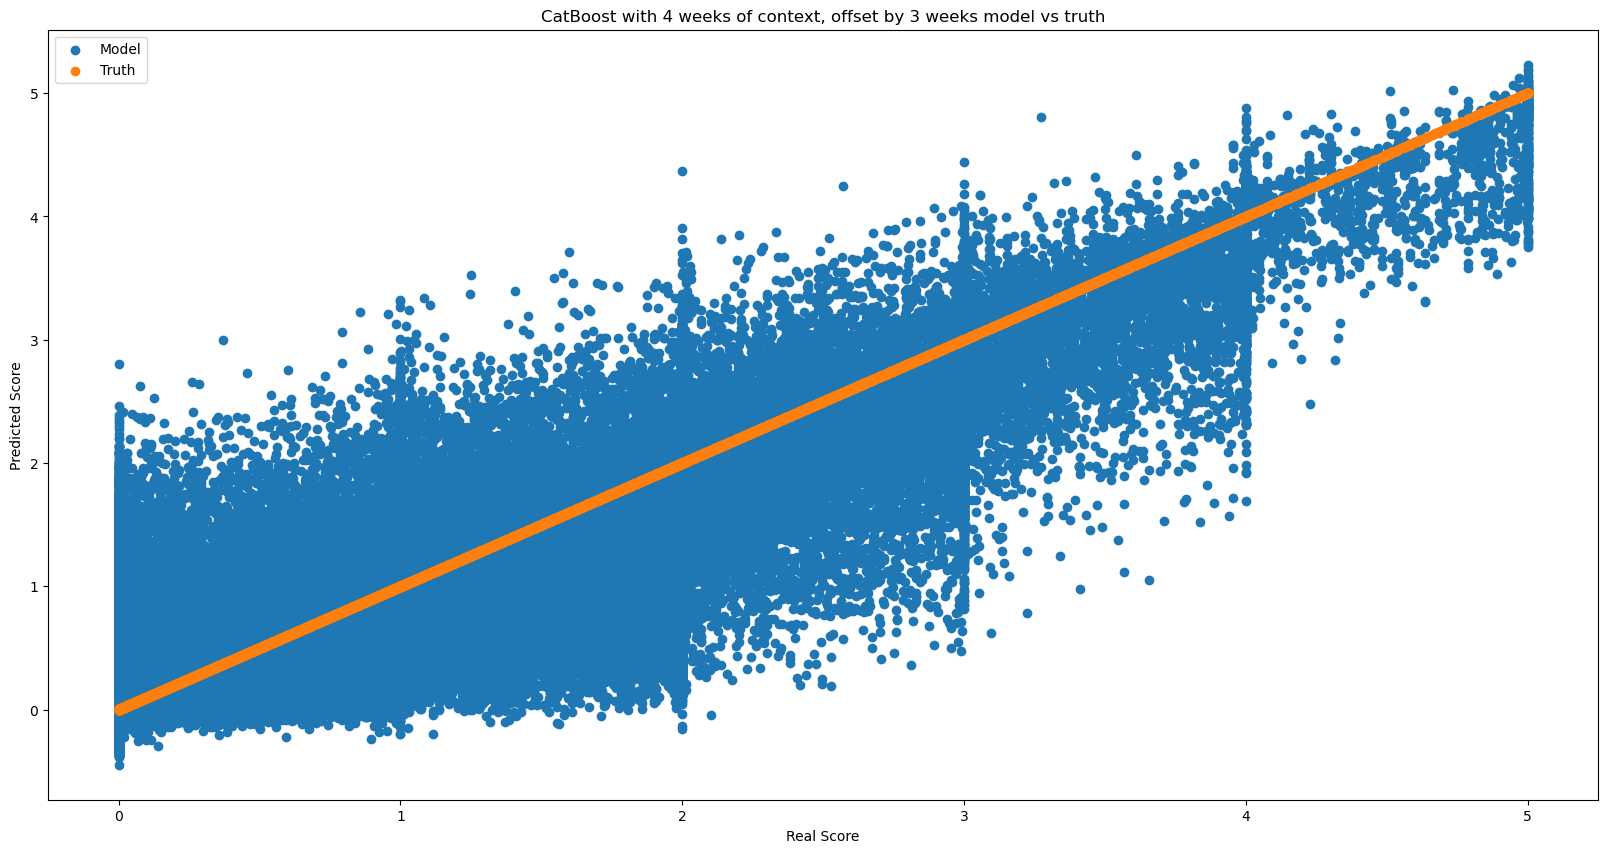

Mean Squared Error:  0.13304610251986743
Mean Absolute Error:  0.218710340927023
R2 Score:  0.8132528202731202


In [92]:
# evaluate catboost regressor
model4_preds = model4.predict(testX)
regression_metric(test4['score'], model4_preds, 'CatBoost with 4 weeks of context, offset by 3 weeks') 

### MLP Regressor on the same data as most previous experiment

In [84]:
#train MLP regressor
from sklearn.neural_network import MLPRegressor

model5 = MLPRegressor()
model5.fit(train4.drop(['score'],axis=1),train4['score'])

MLPRegressor()

In [85]:
#save MLP regressor
pickle.dump(model5, open('model5_mlp_regression_experiments_with_weekly_avg.pkl', 'wb'))

In [86]:
import pickle
model5 = pickle.load(open('model5_mlp_regression_experiments_with_weekly_avg.pkl', 'rb'))

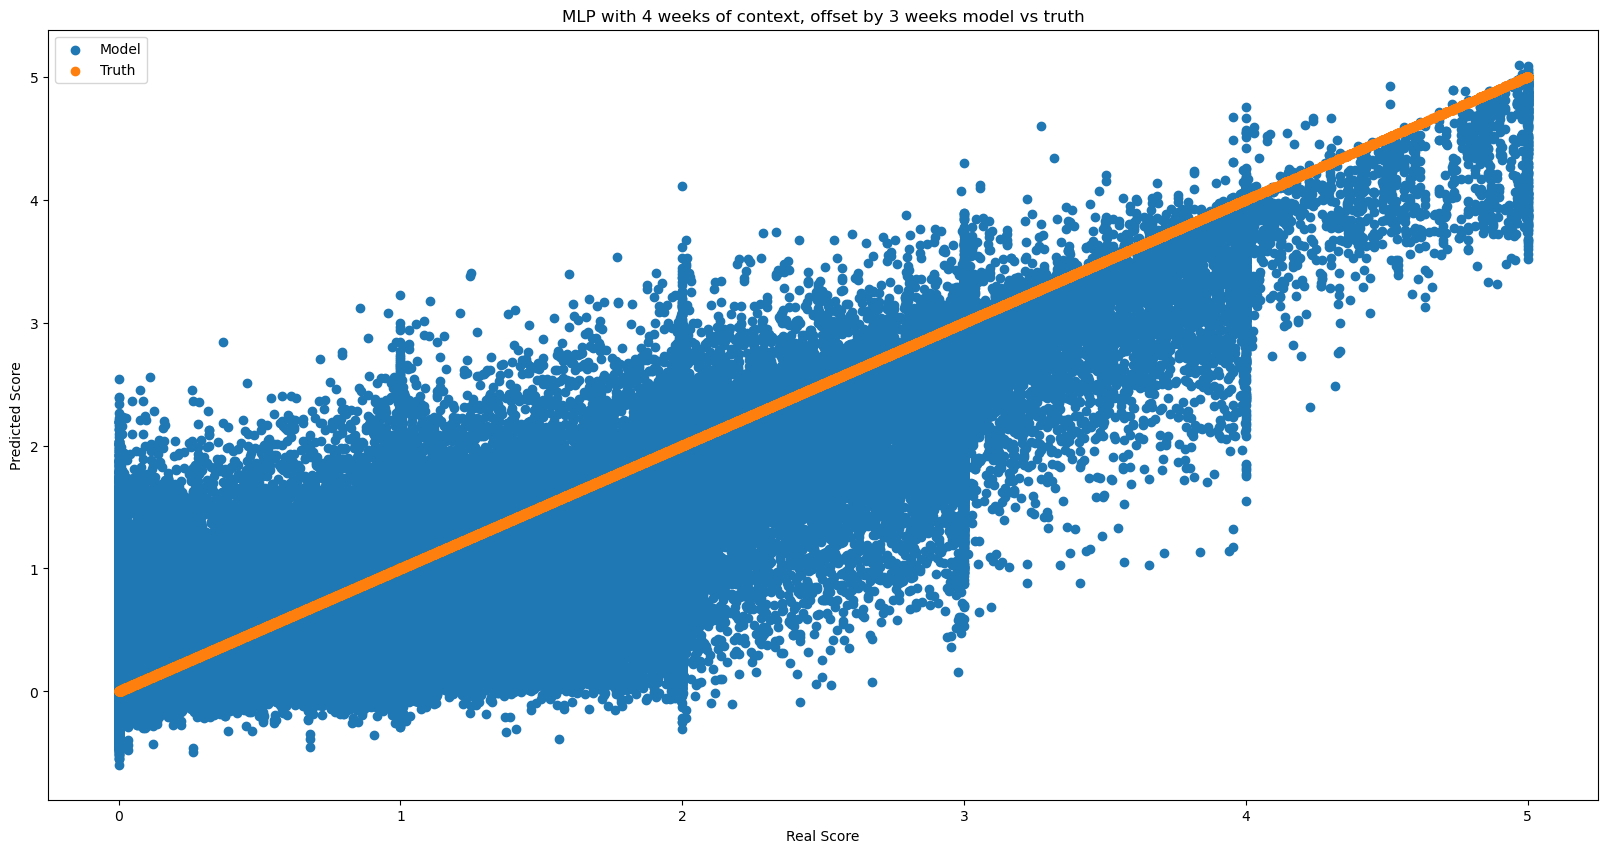

Mean Squared Error:  0.14258602228359735
Mean Absolute Error:  0.21451308661431473
R2 Score:  0.7998623257230731


In [87]:
model5_preds = model5.predict(test4.drop(['score'],axis=1))
regression_metric(test4['score'], model5_preds, 'MLP with 4 weeks of context, offset by 3 weeks')

## Lag Feature analysis

I want to see what the correlation of lag features with the score column is, without any lagged scores present. I'm going to make it so that we are predicting 4 weeks out.

In [ ]:
train5, test5 = get_fresh_data()

In [ ]:
cols = train5.columns.to_list()
cols.remove('fips')
cols.remove('score')
cols.remove('lat')
cols.remove('long')
for x in cols:
    train5 = add_lag_features('fips',x,4,0,train5)
    test5 = add_lag_features('fips',x,4,0,test5)

train5 = add_lag_features('fips','score',5,4,train5)
test5 = add_lag_features('fips','score',5,4,test5)

In [ ]:
NUM_WEEKS_TO_FORECAST = 4

In [ ]:
train5 = shift_target(train5, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test5 = shift_target(test5, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train5 = rm_fips_null(train5)
test5 = rm_fips_null(test5)

In [ ]:
corr_mat = train5.cov() 

In [ ]:
corr_mat.style.background_gradient(cmap ='viridis')
        .set_properties(**{'font-size': '10px'})

In [ ]:
pd.DataFrame(corr_mat['score'].sort_values(ascending=False)).head(20)

,score
T2M_MAX_lag_4,2.173065
T2M_MAX_lag_3,2.169697
T2M_MAX_lag_2,2.165255
T2M_MAX_lag_1,2.145306
T2M_MAX,2.129127
TS_lag_4,1.665921
TS_lag_3,1.658021
TS_lag_2,1.647876
TS_lag_1,1.622199
TS,1.595858


In [ ]:
corr_mat['score'].sort_values(ascending=False)['score_lag_5']

1.1139879995589779

In [ ]:
from catboost import CatBoostRegressor

model6 = CatBoostRegressor()
model6.fit(train5.drop(['score'],axis=1),train5['score'], verbose=False)

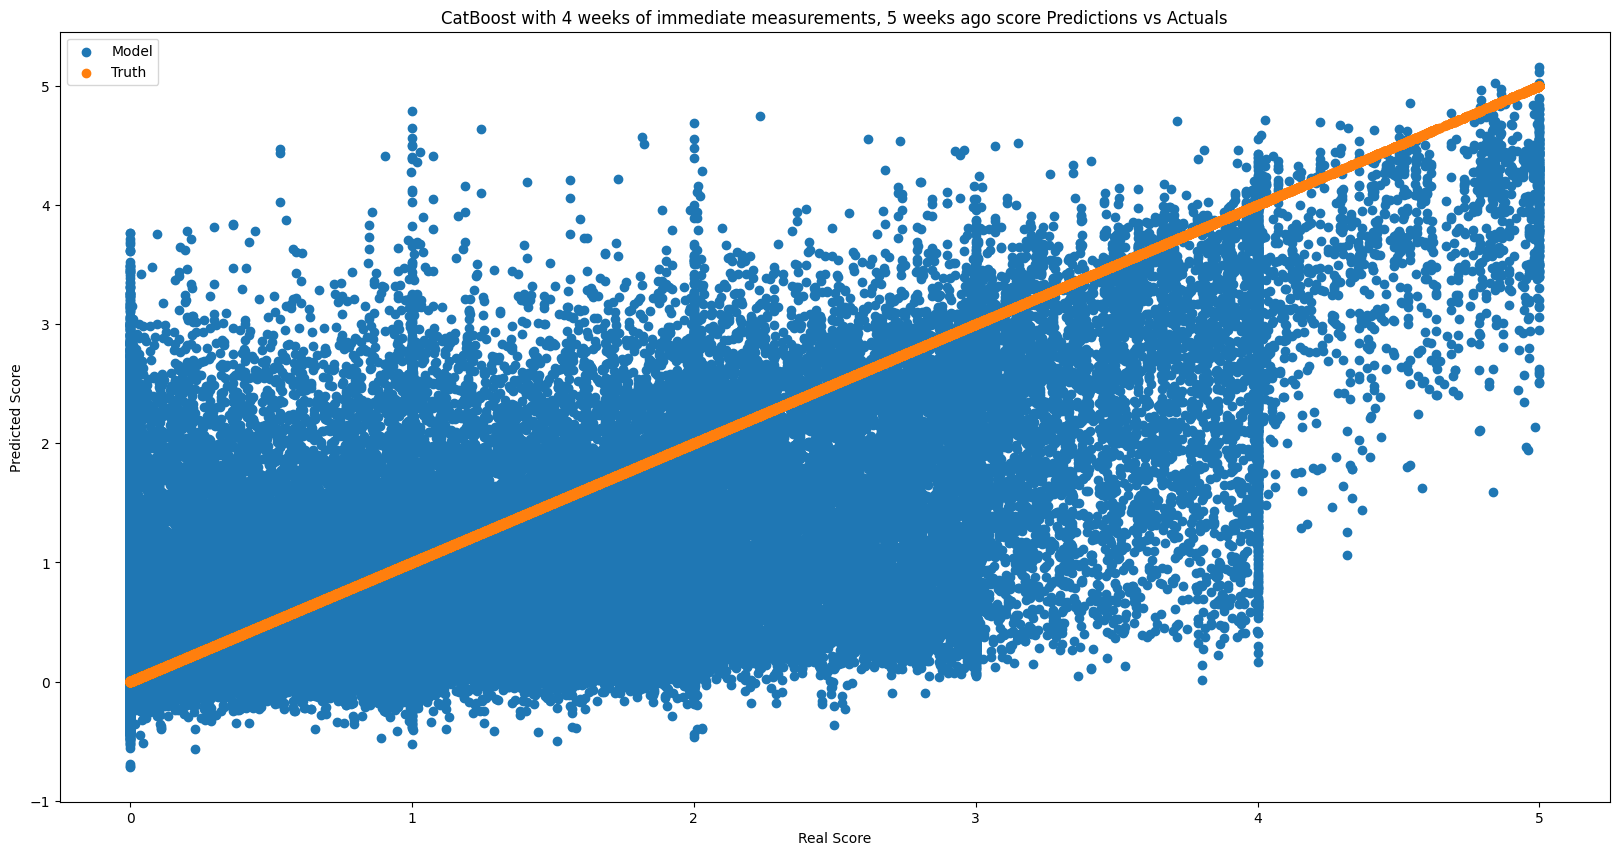

Mean Squared Error:  0.3894764951342707
Mean Absolute Error:  0.41292568271612584
R2 Score:  0.4633012256031167


In [ ]:
model6_preds = model6.predict(test5.drop(['score'],axis=1))
regression_metric(test5['score'], model6_preds, 'CatBoost with 4 weeks of immediate measurements, 5 weeks ago score')

In [ ]:
model6.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_5,35.361595
1,long,8.863837
2,lat,4.439520
3,T2M_MAX,4.045708
4,TS,2.144993
...,...,...
88,WS10M_MIN_lag_3,0.032406
89,WS10M_MIN_lag_4,0.026806
90,WS50M_RANGE_lag_3,0.021418
91,WS10M_MIN_lag_2,0.019835


Unfortunately, it seems that with a far enough prediction horizon, some degree of recent score knowledge is needed. However, it is also apparent that not all of the lag features are contributing equally. Some of the lag features should be prioritized more, and some can be dropped. 

## Maximal Prediction threshold - FINAL MODELS
----

I want to see how far out we can predict using a catboost regressor, 4 weeks of score context, and intelligently lagged weather measurements.

In [64]:
trainf, testf = get_fresh_data()

trainf.columns

Index(['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
       'score', 'lat', 'long'],
      dtype='object')

In [65]:
tcols = [x for x in trainf.columns if 'T2' in x] #The non-wind columns seem to matter the most. Therefore, we'll lag these.
tcols.append("TS")
tcols.append("PRECTOT")
tcols.append("QV2M")
for x in tcols:
    trainf = add_lag_features('fips',x,2,0,trainf)
    testf = add_lag_features('fips',x,2,0,testf)

trainf = add_lag_features('fips','score',4,0,trainf) #we saw in our first experiment that after a few weeks of score context, it stopped mattering as much
testf = add_lag_features('fips','score',4,0,testf)

In [66]:
trainf_1 = shift_target(trainf, 1, 'score', 'fips')
testf_1 = shift_target(testf, 1, 'score', 'fips')

trainf_2 = shift_target(trainf, 2, 'score', 'fips')
testf_2 = shift_target(testf, 2, 'score', 'fips')

trainf_3 = shift_target(trainf, 3, 'score', 'fips')
testf_3 = shift_target(testf, 3, 'score', 'fips')

trainf_4 = shift_target(trainf, 4, 'score', 'fips')
testf_4 = shift_target(testf, 4, 'score', 'fips')

In [67]:
trainf_1 = rm_fips_null(trainf_1)
testf_1 = rm_fips_null(testf_1)

trainf_2 = rm_fips_null(trainf_2)
testf_2 = rm_fips_null(testf_2)

trainf_3 = rm_fips_null(trainf_3)
testf_3 = rm_fips_null(testf_3)

trainf_4 = rm_fips_null(trainf_4)
testf_4 = rm_fips_null(testf_4)

In [68]:
trainf_1

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,TS_lag_1,TS_lag_2,PRECTOT_lag_1,PRECTOT_lag_2,QV2M_lag_1,QV2M_lag_2,score_lag_1,score_lag_2,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,0.781429,...,4.508571,9.975714,3.641429,0.832857,4.220000,6.692857,2.0,2.0,2.0000,1.0000
2000-02-08,0.000000,101.054286,3.545714,4.377143,-1.231429,-1.180000,12.318571,-2.164286,14.480000,3.640000,...,0.781429,4.508571,3.617143,3.641429,3.178571,4.220000,1.0,2.0,2.0000,2.0000
2000-02-15,1.708571,100.215714,8.087143,13.325714,10.057143,10.061429,20.042857,6.375714,13.668571,12.987143,...,3.640000,0.781429,0.000000,3.617143,3.545714,3.178571,1.0,1.0,2.0000,2.0000
2000-02-22,0.917143,100.998571,7.101429,12.237143,7.655714,7.668571,19.608571,5.337143,14.271429,12.130000,...,12.987143,3.640000,1.708571,0.000000,8.087143,3.545714,1.0,1.0,1.0000,2.0000
2000-02-29,3.852857,100.828571,7.628571,14.057143,9.621429,9.625714,21.797143,7.042857,14.752857,14.005714,...,12.130000,12.987143,0.917143,1.708571,7.101429,8.087143,1.0,1.0,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-22,2.598571,82.920000,3.245714,-0.251429,-4.988571,-4.938571,5.287143,-4.571429,9.857143,-1.217143,...,6.400000,5.360000,0.034286,0.010000,4.197143,3.458571,0.0,0.0,0.0056,0.0056
2016-11-29,0.142857,82.554286,2.585714,-1.075714,-7.574286,-7.472857,4.200000,-4.552857,8.752857,-1.740000,...,-1.217143,6.400000,2.598571,0.034286,3.245714,4.197143,0.0,0.0,0.0000,0.0056
2016-12-06,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,-5.887143,...,-1.740000,-1.217143,0.142857,2.598571,2.585714,3.245714,0.0,0.0,0.0000,0.0000


In [69]:
from catboost import CatBoostRegressor
import pickle

model7_1 = CatBoostRegressor()
model7_1.fit(trainf_1.drop(['score'],axis=1),trainf_1['score'], verbose=False)
model7_1_preds = model7_1.predict(testf_1.drop(['score'],axis=1))


In [75]:
pickle.dump(model7_1, open('model7_1_regression_experiments_with_weekly_avg.pkl', 'wb'))

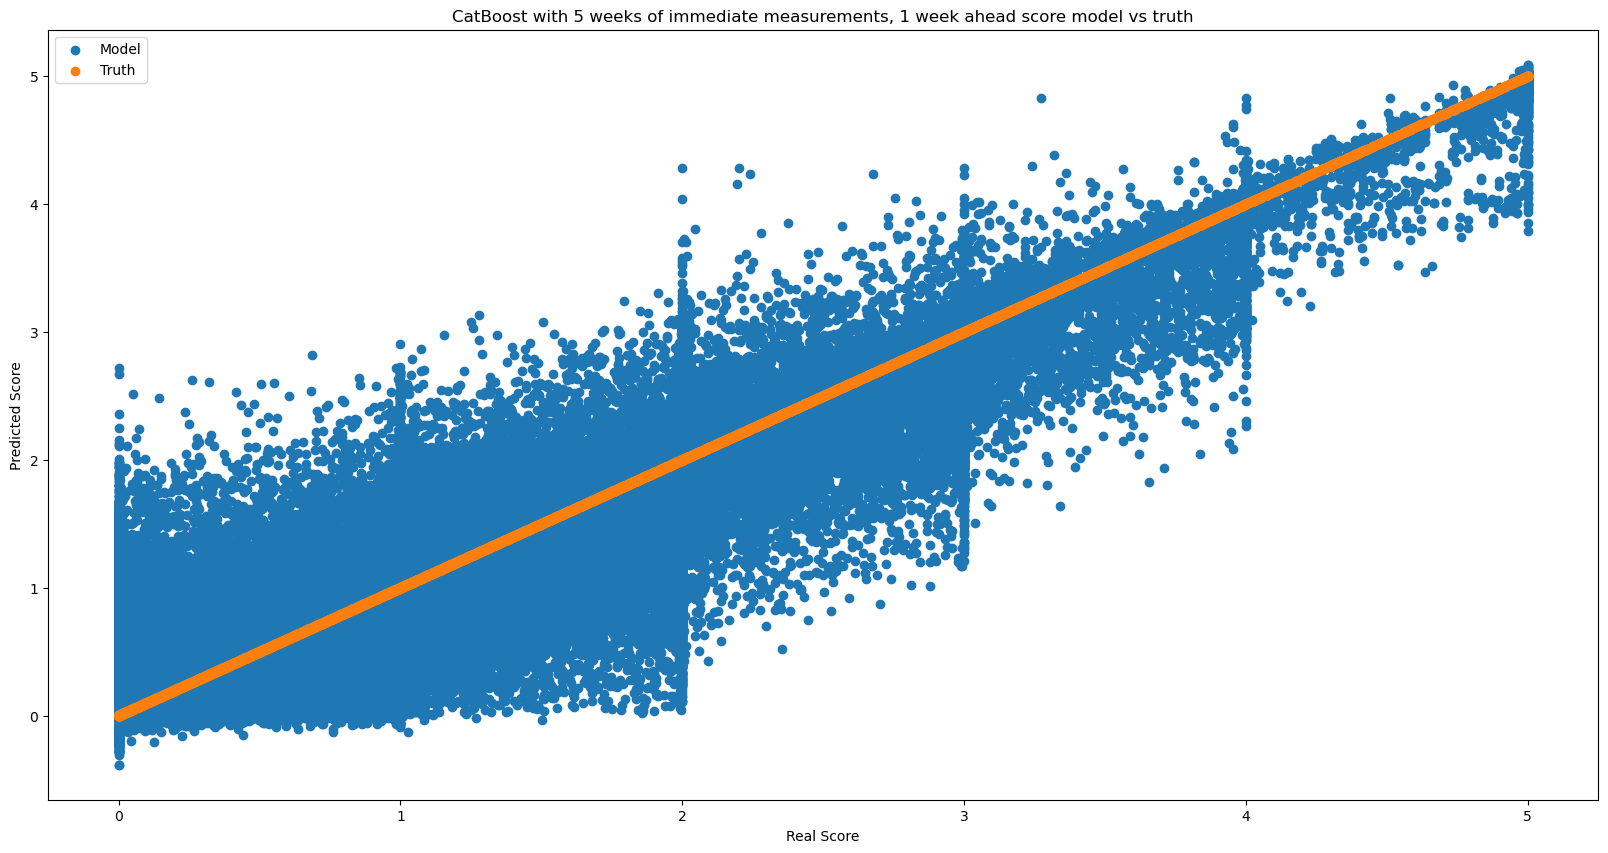

Mean Squared Error:  0.08008508586223408
Mean Absolute Error:  0.15289153737956224
R2 Score:  0.8875903642444247


In [70]:
regression_metric(testf_1['score'], model7_1_preds, 'CatBoost with 5 weeks of immediate measurements, 1 week ahead score')

In [71]:
model7_1.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,70.173238
1,PRECTOT,10.589442
2,long,2.810059
3,PRECTOT_lag_1,2.267418
4,T2M_MAX,1.315528
5,lat,1.168819
6,PRECTOT_lag_2,1.082021
7,T2M_RANGE,0.868345
8,TS,0.573668
9,T2M,0.522852


In [74]:
from catboost import CatBoostRegressor
import pickle

model7_2 = CatBoostRegressor()
model7_2.fit(trainf_2.drop(['score'],axis=1),trainf_2['score'], verbose=False)
model7_2_preds = model7_2.predict(testf_2.drop(['score'],axis=1))

pickle.dump(model7_2, open('model7_2_regression_experiments_with_weekly_avg.pkl', 'wb'))

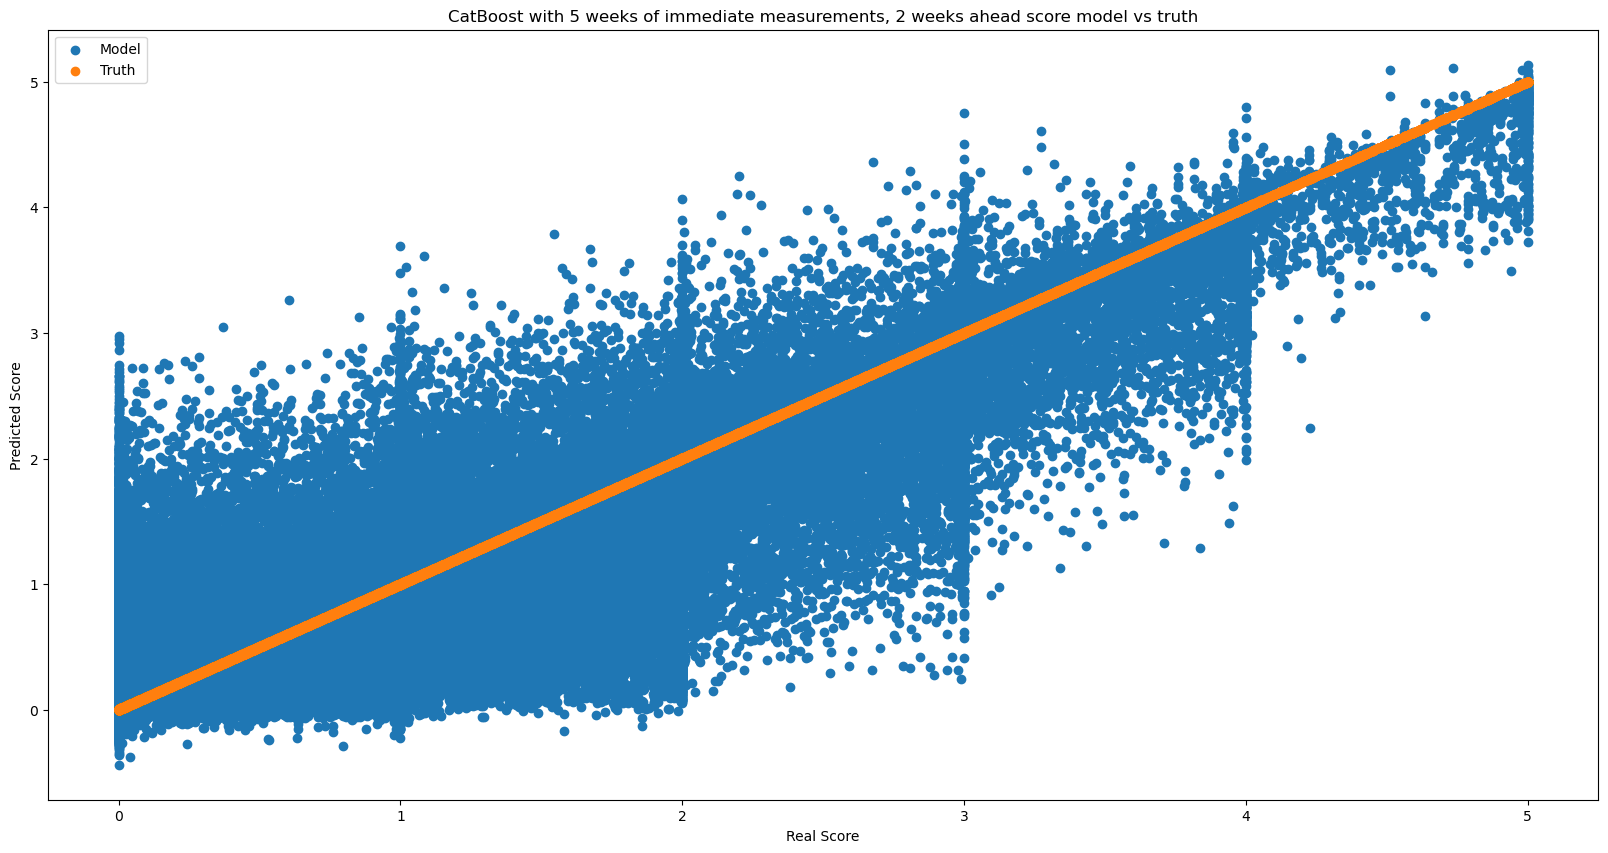

Mean Squared Error:  0.13466054301981054
Mean Absolute Error:  0.20899488003400146
R2 Score:  0.8117351418113324


In [76]:
regression_metric(testf_2['score'], model7_2_preds, 'CatBoost with 5 weeks of immediate measurements, 2 weeks ahead score')


In [77]:
model7_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,60.519409
1,PRECTOT,10.939862
2,long,4.016754
3,PRECTOT_lag_1,3.155651
4,lat,1.789920
5,T2M_MAX,1.734667
6,PRECTOT_lag_2,1.495332
7,T2M_RANGE,1.344194
8,TS,1.035485
9,score_lag_3,1.001625


In [78]:
from catboost import CatBoostRegressor
import pickle

model7_3 = CatBoostRegressor()
model7_3.fit(trainf_3.drop(['score'],axis=1),trainf_3['score'], verbose=False)
model7_3_preds = model7_3.predict(testf_3.drop(['score'],axis=1))

pickle.dump(model7_3, open('model7_3_regression_experiments_with_weekly_avg.pkl', 'wb'))

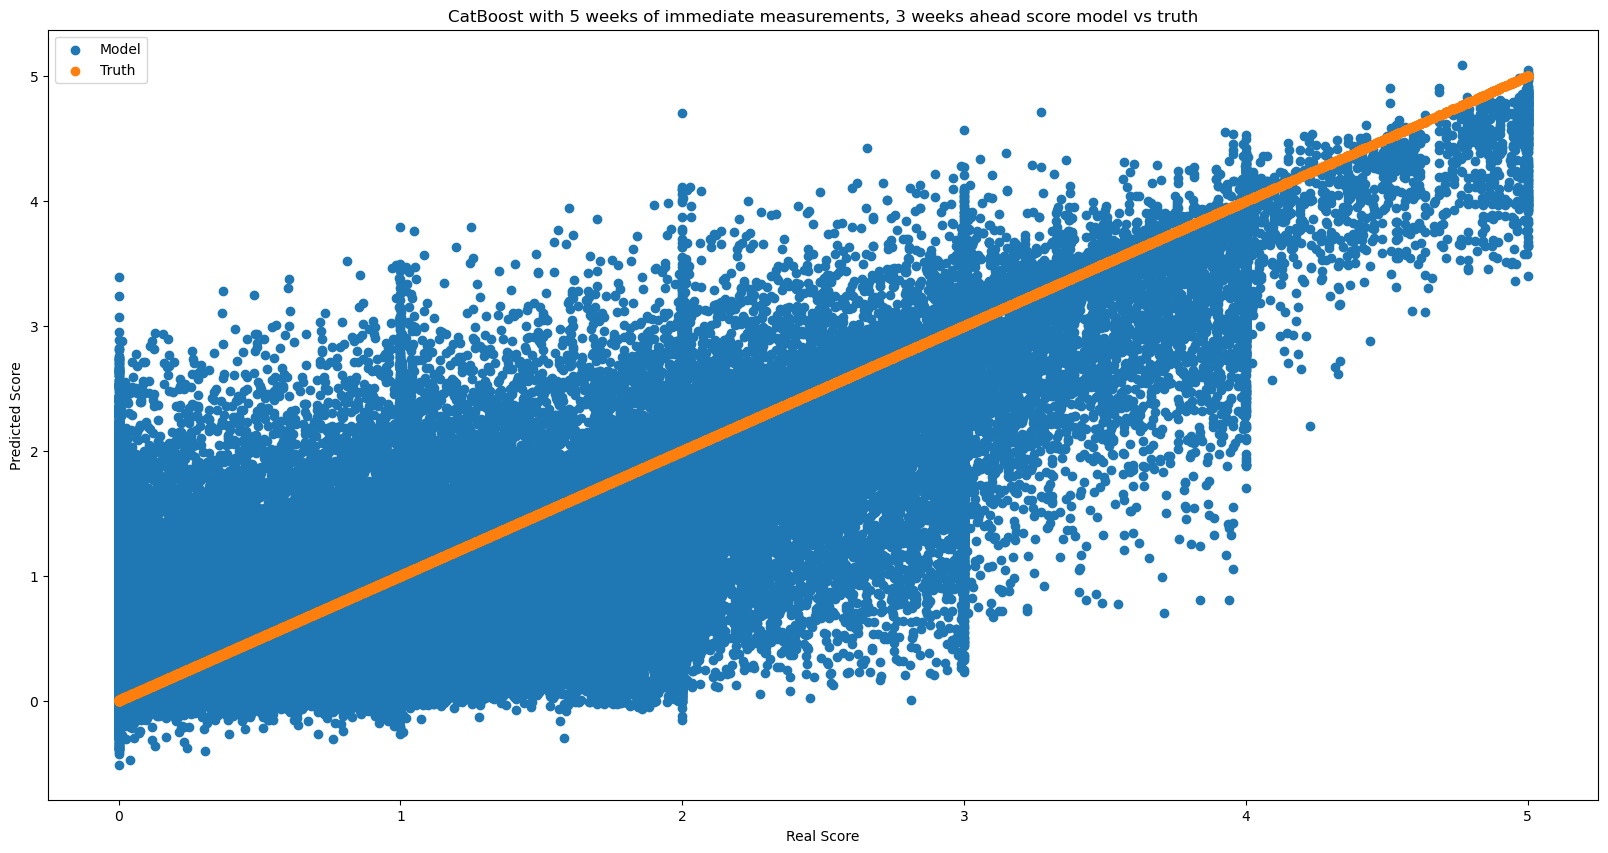

Mean Squared Error:  0.19409841795713279
Mean Absolute Error:  0.26098047282677544
R2 Score:  0.7297944043453665


In [79]:
regression_metric(testf_3['score'], model7_3_preds, 'CatBoost with 5 weeks of immediate measurements, 3 weeks ahead score')

In [80]:
model7_3.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,53.319440
1,PRECTOT,11.679802
2,long,5.036001
3,PRECTOT_lag_1,3.409018
4,lat,2.633978
5,T2M_MAX,2.074349
6,PRECTOT_lag_2,1.481971
7,T2M_RANGE,1.286035
8,T2M_RANGE_lag_1,1.069672
9,score_lag_4,1.046469


In [81]:
from catboost import CatBoostRegressor
import pickle

model7_4 = CatBoostRegressor()
model7_4.fit(trainf_4.drop(['score'],axis=1),trainf_4['score'], verbose=False)
model7_4_preds = model7_4.predict(testf_4.drop(['score'],axis=1))

pickle.dump(model7_4, open('model7_4_regression_experiments_with_weekly_avg.pkl', 'wb'))

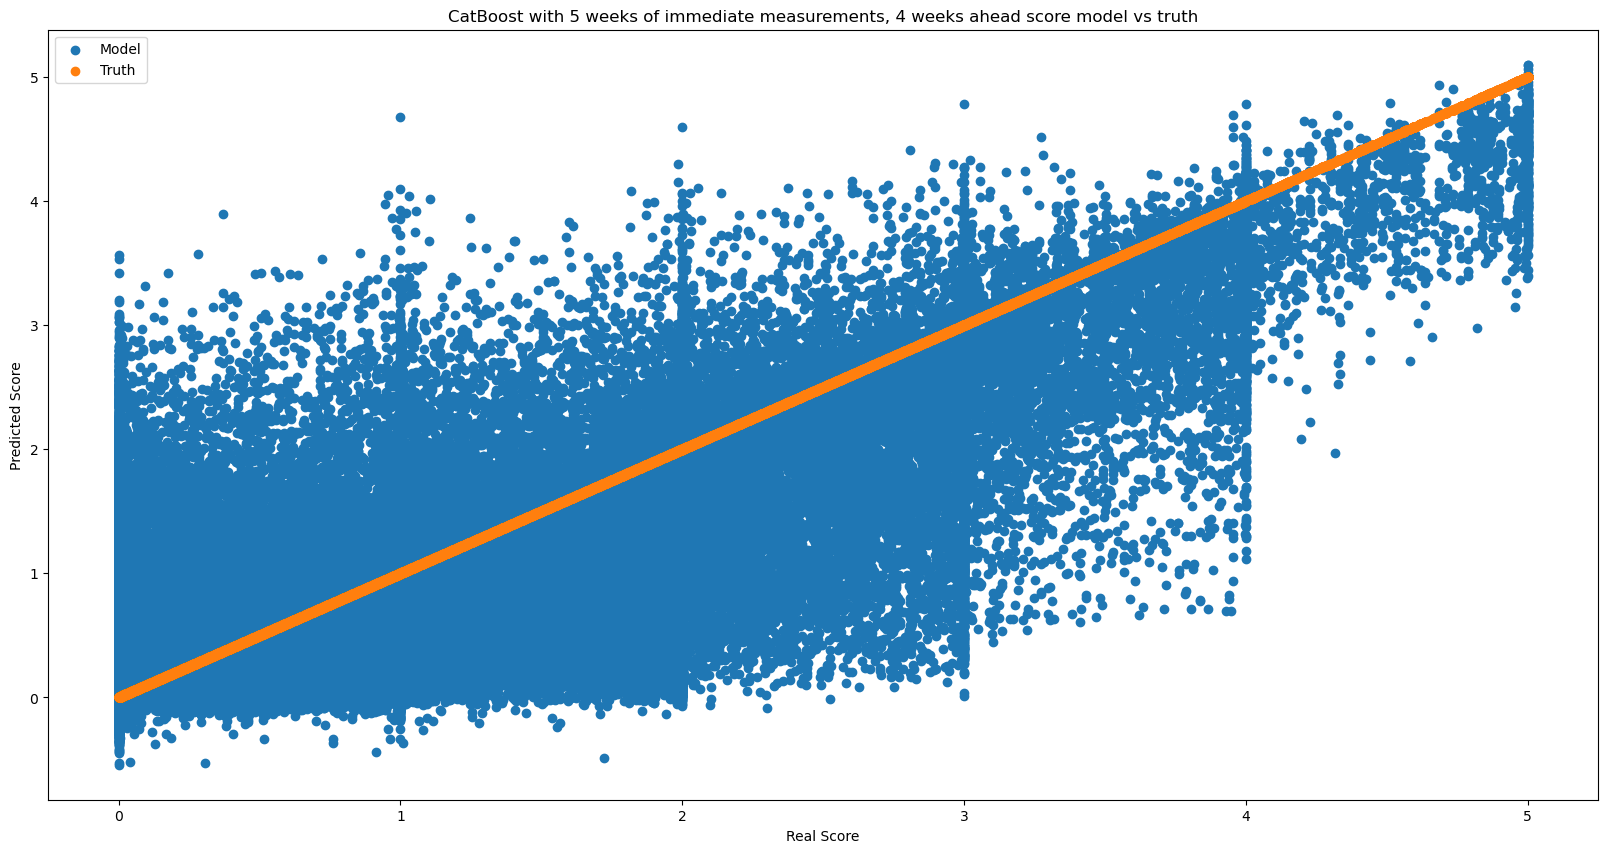

Mean Squared Error:  0.2514643119446016
Mean Absolute Error:  0.3071574970439905
R2 Score:  0.6515755656500076


In [82]:
regression_metric(testf_4['score'], model7_4_preds, 'CatBoost with 5 weeks of immediate measurements, 4 weeks ahead score')

In [83]:
model7_4.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,47.123865
1,PRECTOT,11.280437
2,long,5.980477
3,PRECTOT_lag_1,3.292264
4,lat,3.224083
5,T2M,2.016799
6,T2M_RANGE,1.655644
7,T2M_MAX,1.633770
8,PRECTOT_lag_2,1.594157
9,score_lag_4,1.532607


As we can see very clearly, the R2 and MSE go up as we try to predict further and further out. It is possible that with additional feature engineering, we could extend our prediction horizon, but unfortunately, we did not get the time to try this. The time-series lag features are critical, especially knowledge of past scores. 

One interesting thing to note is that the decision tree based regressor seems to have "buckets" of predictions, denoted by vertical lines on the graph. This is interesting, and the cause of this is not entirely clear. A potential hypothesis is that this is an artefact of making discrete choices, and these buckets graphically show the terminal splits.

Furthermore, the models make intuitive sense. The ground truth from a week ago is the most important feature, followed by position (indicating biome), and precipitation. This is explainable, since drought inherently corresponds to these things.